In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Optimisation parameters
problem_name = "Forrester"
problem_params = {}
time_name = "corrtime"
interface = "job-dependant"
n_workers = 1
acq_name = "EITimeRatio"
time_acq = True
run_no = 1
budget = 1000

acq_params = {
    "n_opt_samples": 1 * 1000,
    "n_opt_bfgs": 10
}

# Left as defaults
save_every = 10
repeat_no = None

In [3]:
import os
import torch
import numpy as np
from aegis import test_problems, util, time_dists, batch
from aegis.optim import AsyncBO, AsyncTimeAcqBO


# set up the saving paths
save_path = util.generate_save_filename(
    time_name,
    problem_name,
    budget,
    n_workers,
    acq_name,
    run_no,
    problem_params,
    acq_params,
    repeat_no=repeat_no,
)

if os.path.exists(save_path):
    load_path = save_path
    print("Loading saved run")
else:
    load_path = util.generate_data_filename(
        problem_name, run_no, problem_params, repeat_no=repeat_no
    )

# load the training data
data = torch.load(load_path)
Xtr = data["Xtr"]
Ytr = data["Ytr"]

# if it has additional arguments add them to the dictionary passed to f
if "problem_params" in data:
    problem_params.update(data["problem_params"])

print(f"Training data shape: {Xtr.shape}")

# load the problem instance
f = getattr(test_problems, problem_name)(**problem_params)

# wrap the problem for torch and so that it resides in [0, 1]^d
f = util.TorchProblem(util.UniformProblem(f))

# instantiate the time function
time_class = getattr(time_dists, time_name)
if interface == "job":
    time_func = time_class()
elif interface == "job-dependant":
    time_func = time_class(f)

# get the acquisition function class
acq_class = getattr(batch, acq_name)

# run the BO
if time_acq:
    asbo = AsyncTimeAcqBO(
        f,
        Xtr,
        Ytr,
        acq_class,
        acq_params,
        budget,
        n_workers,
        q=1,
        time_func=time_func,
        verbose=False,
        interface=interface
    )
else:
    asbo = AsyncBO(
        f,
        Xtr,
        Ytr,
        acq_class,
        acq_params,
        budget,
        n_workers,
        q=1,
        time_func=time_func,
        verbose=False,
        interface=interface
    )

/home/lewis/anaconda3/envs/mp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training data shape: torch.Size([2, 1])


/home/lewis/anaconda3/envs/mp/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


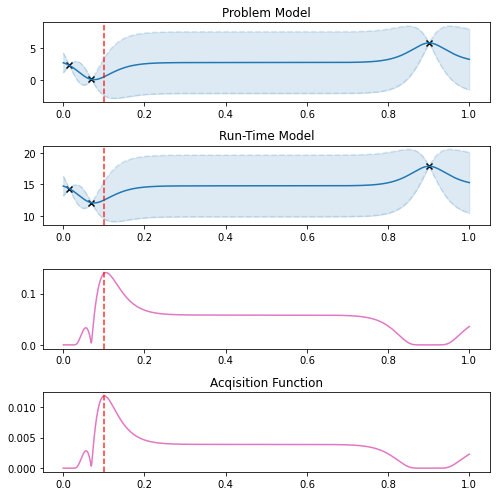

In [5]:
import matplotlib.pyplot as plt
import plotting
from aegis.batch import ratios

asbo.step()

res = asbo.get_results()
models = asbo.get_models()

T_data = asbo.output_transform(asbo.Ytr)
T_time = asbo.output_transform(asbo.time_taken)

plt.rcParams['figure.figsize'] = [7, 7]

fig, axs = plt.subplots(4)
color = np.array([31, 119, 180])/255
plotting.gp_plot(axs[0], models["ProblemModel"], T_data, color=color)
axs[0].set(title="Problem Model")
plotting.gp_plot(axs[1], models["TimeModel"], T_time, color=color)
axs[1].set(title="Run-Time Model")

# Get EI for comparison
EI = ratios.EI(
    models["ProblemModel"],
    asbo.f.lb,
    asbo.f.ub,
    under_evaluation=asbo.ue.get(),
    **acq_params,
)
plotting.acq_plot(axs[2], EI)
axs[2].set(title="EI For Comparison")

if time_acq:
    asbo.acq.update(models["ProblemModel"], asbo.ue.get(), models["TimeModel"])
else:
    asbo.acq.update(models["ProblemModel"], asbo.ue.get())

# Acq function we're using
plotting.acq_plot(axs[3], asbo.acq)
axs[3].set(title="Acqisition Function")
plotting.mark_acq_choice_plot(axs, asbo.acq)
fig.tight_layout()